In [9]:
using JuMP
import Gurobi
import Random
import Plots

PDPTW with IP

Build PDPTW model
- P = {2,...,n+1}, D = {n+2,...,2n+1}, depot = {1, 2n+2}, V = union of P, D ,and depot 
- one-to-one problem 



Data
- random seed
- num_requests & num_locations
- time_windows
- service_times
- locations
- travel_times

In [32]:
seed_value = 39

Random.seed!(seed_value)

# num_requests & num_locations
num_requests = 5
num_locations = 2 * num_requests + 2 # Includes two depot nodes

# time windows
time_windows = vcat([(rand(0:30), rand(30:60)) for _ in 1:num_requests], [(rand(30:60), rand(60:90)) for _ in 1:num_requests])
time_windows = vcat((0, 0), time_windows, (0, 100)) # add depot 

# service times
service_times = rand(1:3, 2*num_requests) 
service_times = vcat(0, service_times, 0) # add depot service time 

# locations
locations = [rand(0:10, 2) for _ in 1:(2*num_requests + 1)]
locations = vcat(locations, [locations[1]]) # add end depot 

# depot
depot_start = 1
depot_end = size(locations, 1)
# generate_distance_matrix
function generate_distance_matrix(locations)
    num_locations = length(locations)
    
    travel_times = zeros(num_locations, num_locations)
    
    for i in 1:num_locations
        for j in 1:num_locations
            if i != j
                dx = locations[i][1] - locations[j][1]
                dy = locations[i][2] - locations[j][2]
                travel_times[i, j] = round(sqrt(dx^2 + dy^2))
            end
        end
    end
    
    return travel_times
end

# travel_times
travel_times = generate_distance_matrix(locations)


12×12 Matrix{Float64}:
  0.0   7.0  11.0   9.0  5.0  8.0  9.0  11.0  8.0  6.0  7.0   0.0
  7.0   0.0   7.0  10.0  6.0  3.0  4.0   6.0  1.0  9.0  1.0   7.0
 11.0   7.0   0.0   6.0  7.0  4.0  3.0   1.0  6.0  9.0  6.0  11.0
  9.0  10.0   6.0   0.0  5.0  7.0  7.0   7.0  9.0  4.0  9.0   9.0
  5.0   6.0   7.0   5.0  0.0  4.0  5.0   6.0  6.0  4.0  5.0   5.0
  8.0   3.0   4.0   7.0  4.0  0.0  1.0   4.0  2.0  8.0  2.0   8.0
  9.0   4.0   3.0   7.0  5.0  1.0  0.0   2.0  3.0  8.0  3.0   9.0
 11.0   6.0   1.0   7.0  6.0  4.0  2.0   0.0  5.0  9.0  5.0  11.0
  8.0   1.0   6.0   9.0  6.0  2.0  3.0   5.0  0.0  9.0  1.0   8.0
  6.0   9.0   9.0   4.0  4.0  8.0  8.0   9.0  9.0  0.0  9.0   6.0
  7.0   1.0   6.0   9.0  5.0  2.0  3.0   5.0  1.0  9.0  0.0   7.0
  0.0   7.0  11.0   9.0  5.0  8.0  9.0  11.0  8.0  6.0  7.0   0.0

Build PDPTW model
- input: time_windows, travel_times, service_times
- loads
- capacity
- pickup and delivery locations(P, D)
- variables: start time(T), decision(x), load(Q)
- objective: minimize total travel time
- constraints: ... 

In [33]:
function build_pdptw_model(time_windows, travel_times, service_times)
    model = Model(Gurobi.Optimizer)

    # num_requests & num_locations
    num_locations = size(time_windows, 1)
    num_requests = div(num_locations - 2, 2)

    # loads
    loads = [1 for _ in 1:num_requests] # pickup
    loads = vcat(loads, -loads) # add delivery
    loads = vcat(0, loads, 0) # add depot

    # capacity
    capacity = 3

    # pickup & delivery points 
    P = [i for i in 2:num_requests + 1]
    D = [i for i in num_requests + 2:2*num_requests + 1]

    # variables
    @variable(model, T[1:num_locations] >= 0) # start time variable
    @variable(model, x[1:num_locations, 1:num_locations], Bin) # decision variable
    @variable(model, Q[1:num_locations] >=0) # load variable 

    # objective function: minimize total travel time 
    @objective(model, Min, sum(travel_times .* x)) 
    
    # constraints
    # (6.18), (6.19)
    for i in P # for all i in P
        @constraint(model, sum(x[i, j] for j = 1:num_locations) == 1)
        @constraint(model, (sum(x[i, j] for j = 1:num_locations) - sum(x[num_requests+i, j] for j = 1:num_locations)) == 0) 
    end
    
    # (6.20), (6.21), (6.22)
    @constraint(model, sum(x[1, j] for j in 1:num_locations) == 1) # start depot
    for i in vcat(P, D)
        @constraint(model, (sum(x[i, j] for j = 1:num_locations) - sum(x[j, i] for j = 1:num_locations)) == 0)
    end
    @constraint(model, sum(x[j, num_locations] for j in 1:num_locations) == 1) # end depot
    
    # time window constraint (6.23)
    for i in 1:num_locations
        for j in 1:num_locations
            @constraint(model, T[j] >= (T[i] + service_times[i] + travel_times[i, j]) * x[i, j])
        end
    end
    
    # (6.27)
    for i in 1:num_locations
        @constraint(model, time_windows[i][1] <= T[i])
        @constraint(model, time_windows[i][2] >= T[i])
    end

    # precedence constraint (6.25)
    for i in P
        @constraint(model, T[num_requests+i] - T[i] - travel_times[i, num_requests+i] - service_times[i] >= 0)
    end

    # load constraint 
    # (6.24)
    for i in 1:num_locations
        for j in 1:num_locations
            @constraint(model, Q[j] >= (loads[j] + Q[i]) * x[i,j]) 
        end
    end
    
    # (6.28)
    for i in 1:num_locations
        @constraint(model, Q[i] <= min(capacity, capacity + loads[i]))
        @constraint(model, max(0, loads[i]) <= Q[i])
    end
    return model
    
end

build_pdptw_model (generic function with 1 method)

In [34]:
model = build_pdptw_model(time_windows, travel_times, service_times)
optimize!(model)
objective_value(model)
# Assuming 'model' is the name of your model variable
# Assuming 'model' is the name of your model variable
println("Objective Value: ", objective_value(model))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-26
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 75 rows, 168 columns and 482 nonzeros
Model fingerprint: 0x4660bf30
Model has 288 quadratic constraints
Variable types: 24 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+01]
  Objective range  [1e+00, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
Presolve added 91 rows and 0 columns
Presolve removed 0 rows and 40 columns
Presolve time: 0.00s
Presolved: 268 rows, 179 columns, 1333 nonzeros
Variable types: 73 continuous, 106 integer (105 binary)

Root relaxation: objective 2.750059e+01, 76 iterations

In [35]:
function selected_edges(x::Matrix{Float64}, n)
    return Tuple{Int, Int}[(i, j) for i in 1:n, j in 1:n if x[i, j] > 0.5]
end

selected_edges (generic function with 1 method)

Visualization

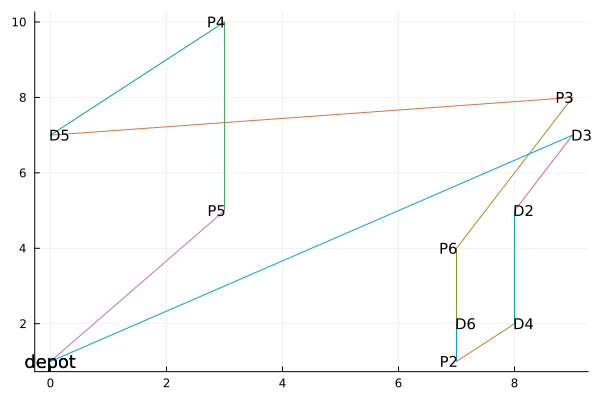

In [64]:
function plot_tour(X, Y, x)
    plot = Plots.plot()

    # Plotting edges
    for (i, j) in selected_edges(x, size(x, 1))
        Plots.plot!([X[i], X[j]], [Y[i], Y[j]]; legend = false)
    end

    # Annotating each point with its index and time window
    for i in 1:length(X)
        if i == 1 || i == length(X)
            Plots.annotate!(X[i], Y[i], Plots.text(string("depot"), :black, 12))
        else
            if i >= 7
                Plots.annotate!(X[i], Y[i], Plots.text(string("D$(i-num_requests)"), :black, 10, :left))
            else         
                Plots.annotate!(X[i], Y[i], Plots.text(string("P$i"), :black, 10, :right))
            end
        end
    end
    return plot
end

X = getindex.(locations, 1)
Y = getindex.(locations, 2)

plot_tour(X, Y, value.(model[:x]))

Save model and solution
- constraints
- results

In [30]:
# Save the model and solution
JuMP.write_to_file(model, "example_model.lp")

open("example_result.txt", "w") do file
    if termination_status(model) == MOI.OPTIMAL || termination_status(model) == MOI.LOCALLY_SOLVED
        println(file, "An optimal solution has been found:")
        println(file, "Optimal objective value: ", objective_value(model))
      
        # Route reconstruction
        route = [depot_start]
        current_node = depot_start
        x = model[ :x]
        T = model[ :T]
        Q = model[ :Q]
        while current_node != depot_end
            for i in 1:num_locations
                for j in 1:num_locations
                    if value(x[i,j]) > 0.9
                        if i == current_node
                            println(file, "Node j")
                            push!(route, j)
                            current_node = j
                        end
                    end
                end
            end
        end
        
        println(file, "Vehicle Route: ", route)
        
        # Print the service start times
        println(file, "\nService start times:")
        for i in 1:num_locations
            println(file, "Node $i: ", value(T[i]))
        end
        
        # Print the vehicle loads
        println(file, "\nVehicle loads after each node:")
        for i in 1:num_locations
            println(file, "Node $i: ", value(Q[i]))
        end
        
    else
        println(file, "No optimal solution found. Status: ", termination_status(model))
    end
end